# Social Dimensions of the Eaton and Palisades Fires
*Author: Melannie Moreno Rolón*

Access the link to the GitHub repository [here](https://github.com/mmorenorolon/eaton-palisades-eji-false-imagery.git) for more information about this project.

## Purpose:

This notebook uses the 2024 California Environmental Justice Index (EJI) dataset to examine how social vulnerability intersects with wildfire exposure in Los Angeles County. Specifically, it identifies the census tracts that overlap the Eaton and Palisades fire perimeters and evaluates the percentage of residents with disabilities (`E_DISABL`) in those communities. The goal of this analysis is to contextualize wildfire impacts beyond the physical burn scars by incorporating demographic indicators that may influence a community’s ability to prepare for, respond to, and recover from fire events. By mapping disability prevalence within fire-affected tracts, this notebook provides a foundation for understanding how environmental hazards and social vulnerability overlap spatially.

## Highlights:

- Integrated Fire Perimeter & EJ Data:

Used the 2025 Eaton and Palisades fire perimeter datasets along with the 2024 California Environmental Justice Index (EJI) geodatabase to examine how wildfire impacts intersect with community-level vulnerability indicators.

- Spatial Overlap and Clipping Analysis:

Identified census tracts intersecting the Eaton and Palisades fire perimeters using spatial joins (`geopandas.sjoin()`), then used `geopandas.clip()` to extract only the tract areas physically within each fire boundary. Created exploratory maps for both fires and compared fire-perimeter size relative to affected census tracts, while discussing conceptual differences between spatial joining vs. clipping.

- Basemap Visualization Using Contextily:

Added basemap layers to fire-perimeter maps with `contextily` to provide geographic context and improve interpretability.

- Environmental Justice Mapping:

Visualized the selected EJI variable(`E_DISABL`) across fire-affected census tracts to understand how social vulnerability and wildfire exposure intersect spatially.

## About the Data: Dataset Descriptions

### Environmental Justice Index (EJI) Data:

This notebook uses the 2024 Environmental Justice Index (EJI) dataset for California, developed by the [Agency for Toxic Substances and Disease Registry (ATSDR)](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html). The EJI provides census-tract–level indicators related to environmental burden, socioeconomic factors, and community health vulnerability. For this analysis, we focus on the variable `E_DISABL`, which reports the percentage of people with a disability in each census tract. This variable helps contextualize wildfire exposure by identifying communities that may face additional challenges during evacuation, emergency response, and recovery.

Date Accessed: 11/19/2025

### Fire Perimeter Data:
The Palisades and Eaton Dissolved Fire Perimeters dataset, published on January 21, 2025 by the County of Los Angeles, provides dissolved boundary polygons for the Eaton and Palisades Fires. Derived from the NIFC FIRIS fire service, which originally contained daily perimeter snapshots, the boundaries were merged to create a single burn perimeter for each fire. One Eaton record (mission 2025-CALAC-009087) was excluded because buffered “destroyed” points did not reliably represent burned areas. The dataset is hosted on [ArcGIS Hub](https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) and includes geospatial layers for both fire perimeters, which supports wildfire impact analysis, mapping and environmental monitoring.

Date Accessed: 11/19/2025

#### **Import Libraries and Data**

I first imported the libraries and loaded the dataframes required to perform the environmental justice mapping analysis. 

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.patches as mpatches

# Save each file path
eaton_fire_fp = 'data/Eaton_Perimeter_20250121/Eaton_Perimeter_20250121.shp'
palis_fire_fp = 'data/Palisades_Perimeter_20250121/Palisades_Perimeter_20250121.shp'
ca_eji_fp = 'data/EJI_2024_California_GDB/EJI_2024_California/EJI_2024_California.gdb'

# Read in each geodataframe 
eaton_fire = gpd.read_file(eaton_fire_fp)
palis_fire = gpd.read_file(palis_fire_fp)
ca_eji = gpd.read_file(ca_eji_fp)

#### **Eaton Fire Perimeter Data Exploration**

I carried out data exploration to understanding the fire perimeter data's structure and identify if data cleaning may be necessary to improve data quality before use. 

In [2]:
# View the head of the geodataframe
print(eaton_fire.head())

# Inspect the data types of the Eaton fire perimeter data
print(eaton_fire.dtypes)

# Identify the names of the columns in the geodataframe
(eaton_fire.columns)

# Confirm that the dataframe is of geodataframe type
print(type(eaton_fire))

   OBJECTID            type    Shape__Are  Shape__Len  \
0         1  Heat Perimeter   2206.265625  270.199719   
1         2  Heat Perimeter  20710.207031  839.204218   
2         3  Heat Perimeter   3639.238281  250.304502   
3         4  Heat Perimeter   1464.550781  148.106792   
4         5  Heat Perimeter   4132.753906  247.960744   

                                            geometry  
0  POLYGON ((-13146936.686 4051222.067, -13146932...  
1  POLYGON ((-13150835.463 4052713.929, -13150831...  
2  POLYGON ((-13153094.697 4053057.596, -13153113...  
3  POLYGON ((-13145097.740 4053118.235, -13145100...  
4  POLYGON ((-13153131.126 4053196.882, -13153131...  
OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object
<class 'geopandas.geodataframe.GeoDataFrame'>


#### Palisades Fire Perimeter Data Exploration

We repeated the same data exploration process for the Palisades Fire Perimeter geodataframe.

In [3]:
# View the head of the geodataframe
print(palis_fire.head())

# View the data types of each column
print(palis_fire.dtypes)

# View the names of the variables
print(palis_fire.columns)

# Confirm that the dataset is of type geodataframe
print(type(palis_fire))

   OBJECTID            type    Shape__Are   Shape__Len  \
0         1  Heat Perimeter   1182.082031   267.101144   
1         2  Heat Perimeter   2222.488281   185.498783   
2         3  Heat Perimeter     21.011719    22.412814   
3         4  Heat Perimeter    214.992188    76.639180   
4         5  Heat Perimeter  44203.453125  1569.259764   

                                            geometry  
0  POLYGON ((-13193543.302 4032913.077, -13193543...  
1  POLYGON ((-13193524.155 4033067.953, -13193524...  
2  POLYGON ((-13193598.085 4033158.222, -13193598...  
3  POLYGON ((-13193654.249 4033146.033, -13193656...  
4  POLYGON ((-13194209.580 4033236.320, -13194209...  
OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object
Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object')
<class 'geopandas.geodataframe.GeoDataFrame'>


To finish off our data exploration of the fire perimeters, we verified that both geodataframes' CRSs match.

In [5]:
# Check that CRSs match
palis_fire.crs == eaton_fire.crs

True

#### **EJI Data Exploration**

We repeated the data exploration process for the EJI dataset.

In [7]:
# View the head of the dataframe
print(ca_eji.head(3))

# Check the data types of the geodataframe
ca_eji.dtypes

# Check the names of the columns for the geodataframe
ca_eji.columns

# Confirm that the EJI dataframe is of type geodataframe
type(ca_eji)

   OBJECTID STATEFP COUNTYFP TRACTCE             AFFGEOID        GEOID  \
0     11620      06      077  005127  140000US06077005127  06077005127   
1     11557      06      077  003406  140000US06077003406  06077003406   
2     11594      06      077  004402  140000US06077004402  06077004402   

    GEOID_2020              COUNTY   StateDesc STATEABBR  ... TWOMORE  \
0  06077005127  San Joaquin County  California        CA  ...   408.0   
1  06077003406  San Joaquin County  California        CA  ...   203.0   
2  06077004402  San Joaquin County  California        CA  ...   132.0   

   E_TWOMORE  OTHERRACE  E_OTHERRACE  Tribe_PCT_Tract  Tribe_Names  \
0        5.4        0.0          0.0              0.0         -999   
1        5.4        0.0          0.0              0.0         -999   
2        2.2        0.0          0.0              0.0         -999   

   Tribe_Flag  Shape_Length    Shape_Area  \
0        -999   5909.703135  1.962577e+06   
1        -999   3805.322542  8.541741e+

geopandas.geodataframe.GeoDataFrame

Our first task is to spatially join the EJI data with the Palisades fire perimeter using `geopandas.sjoin()` to get a `geopandas.GeoDataFrame` that will have only have the census tracts intersecting the Palisades fire perimeter. Afterwards, we will create an exploratory map showing the census tracts that intersect the Palisades and Eaton fire perimeters. 

Before that, we must check that all CRSs match.

In [14]:
# Verify CRSs match
print(ca_eji.crs == palis_fire.crs)
print(ca_eji.crs == eaton_fire.crs)

False
False


Because the CRSs don't match, we must reproject the fire perimeter datasets to match the EJI dataset.

In [4]:
# Reproject all datasets to the same crs
palis_fire = palis_fire.to_crs(ca_eji.crs)
eaton_fire = eaton_fire.to_crs(ca_eji.crs)

After reprojecting the datasets, I spatially joined the Palisades fire perimeter data to determine what census tracts intersect the fire boundaries.

In [5]:
# Get the EJI tracts intersecting the palisades fire perimeter
eji_palisades_join = gpd.sjoin(ca_eji, palis_fire, how='inner', predicate='intersects')

# Check the output dataframe
eji_palisades_join.head()

,OBJECTID_left,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY,StateDesc,STATEABBR,...,Tribe_Names,Tribe_Flag,Shape_Length,Shape_Area,geometry,index_right,OBJECTID_right,type,Shape__Are,Shape__Len
1328,6505,06,037,262706,140000US06037262706,06037262706,06037262706,Los Angeles County,California,CA,...,-999,-999,6486.563559,2.147847e+06,"MULTIPOLYGON (((-2045938.733 -143906.769, -204...",0,1,Heat Perimeter,1182.082031,267.101144
1328,6505,06,037,262706,140000US06037262706,06037262706,06037262706,Los Angeles County,California,CA,...,-999,-999,6486.563559,2.147847e+06,"MULTIPOLYGON (((-2045938.733 -143906.769, -204...",1,2,Heat Perimeter,2222.488281,185.498783
1328,6505,06,037,262706,140000US06037262706,06037262706,06037262706,Los Angeles County,California,CA,...,-999,-999,6486.563559,2.147847e+06,"MULTIPOLYGON (((-2045938.733 -143906.769, -204...",2,3,Heat Perimeter,21.011719,22.412814
1328,6505,06,037,262706,140000US06037262706,06037262706,06037262706,Los Angeles County,California,CA,...,-999,-999,6486.563559,2.147847e+06,"MULTIPOLYGON (((-2045938.733 -143906.769, -204...",9,10,Heat Perimeter,79397.949219,2620.515743
1328,6505,06,037,262706,140000US06037262706,06037262706,06037262706,Los Angeles County,California,CA,...,-999,-999,6486.563559,2.147847e+06,"MULTIPOLYGON (((-2045938.733 -143906.769, -204...",10,11,Heat Perimeter,22.070312,21.680935


The following plot demonstrates the census tracts that intersect each fire perimeter.

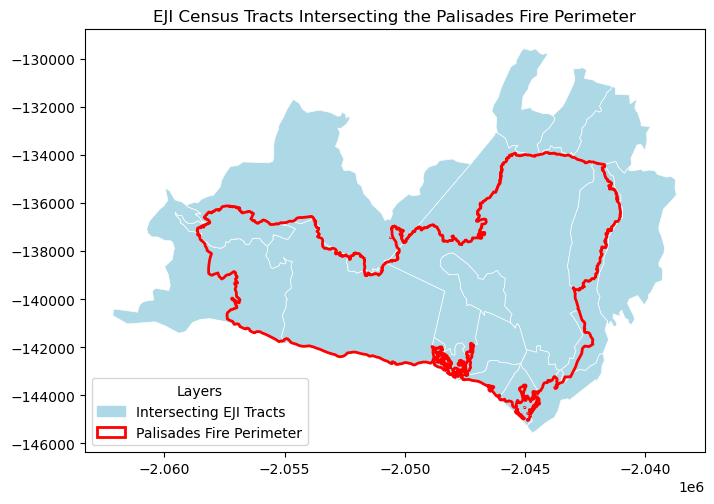

In [12]:
# Generate empty plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the joined dataframe
eji_palisades_join.plot(
    ax=ax, 
    color="lightblue", 
    edgecolor="white", 
    linewidth=0.5,
    label="Intersecting EJI Tracts")

# Plot the Palisades fire boundary
palis_fire.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2,
    label="Palisades Fire Perimeter")

eji_patch = mpatches.Patch(
    color="lightblue", 
    label="Intersecting EJI Tracts")

palis_patch = mpatches.Patch(
    facecolor="none", 
    edgecolor="red",
    linewidth=2,
    label="Palisades Fire Perimeter")

# Insert the title for the plot
ax.set_title("EJI Census Tracts Intersecting the Palisades Fire Perimeter")
ax.legend(handles=[eji_patch, palis_patch], title="Layers", loc='lower left')
plt.show()


How big is the Palisades fire perimeter relative to intersecting census tracts?

In the case of the Palisades Fire, several entire census tracts fall completely inside the fire perimeter, while others intersect only along the edges. This means the fire footprint is large relative to the size of nearby census tracts, covering substantial portions of the local communities. Unlike many wildfires that only clip small parts of multiple tracts, the Palisades Fire burned through whole tracts, indicating that the impacted population and built environment may span multiple full census units.

Next, we repeated the process and spatially joined the Eaton fire boundary with the EJI dataset.

In [9]:
# Get the EJI tracts intersecting the eaton fire perimeter
eji_eaton_join = gpd.sjoin(ca_eji, eaton_fire, how='inner', predicate='intersects')

# View the output dataframe
eji_eaton_join.head()

,OBJECTID_left,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY,StateDesc,STATEABBR,...,Tribe_Names,Tribe_Flag,Shape_Length,Shape_Area,geometry,index_right,OBJECTID_right,type,Shape__Are,Shape__Len
430,7051,06,037,461501,140000US06037461501,06037461501,06037461501,Los Angeles County,California,CA,...,-999,-999,4163.166698,1.004134e+06,"MULTIPOLYGON (((-2007261.137 -136641.466, -200...",1,2,Heat Perimeter,2.071021e+04,839.204218
624,8038,06,037,930400,140000US06037930400,06037930400,06037930400,Los Angeles County,California,CA,...,-999,-999,278402.435077,1.494686e+09,"MULTIPOLYGON (((-2035626.749 -111763.817, -203...",17,18,Heat Perimeter,8.314779e+07,97603.986189
624,8038,06,037,930400,140000US06037930400,06037930400,06037930400,Los Angeles County,California,CA,...,-999,-999,278402.435077,1.494686e+09,"MULTIPOLYGON (((-2035626.749 -111763.817, -203...",14,15,Heat Perimeter,2.405430e+02,59.202170
624,8038,06,037,930400,140000US06037930400,06037930400,06037930400,Los Angeles County,California,CA,...,-999,-999,278402.435077,1.494686e+09,"MULTIPOLYGON (((-2035626.749 -111763.817, -203...",15,16,Heat Perimeter,1.045547e+02,44.121115
624,8038,06,037,930400,140000US06037930400,06037930400,06037930400,Los Angeles County,California,CA,...,-999,-999,278402.435077,1.494686e+09,"MULTIPOLYGON (((-2035626.749 -111763.817, -203...",16,17,Heat Perimeter,8.781250e+00,13.404382


Here, I plotted the spatially joined Eaton fire perimeter with the intersecting EJI census tracts. 

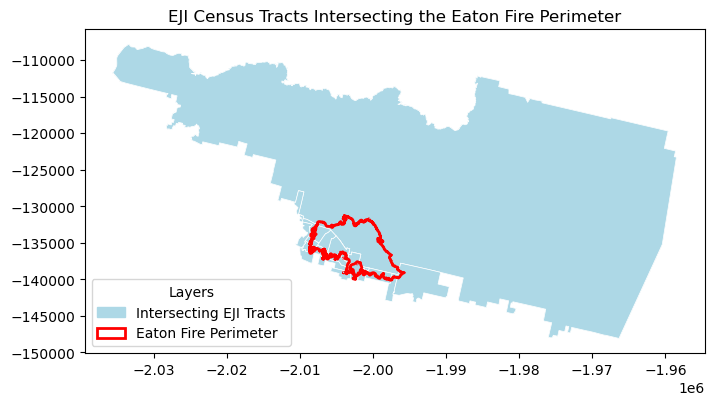

In [11]:
# Generate an empty plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the spatially joined Eaton fire perimeter and EJI data
eji_eaton_join.plot(
    ax=ax, 
    color="lightblue", 
    edgecolor="white", 
    linewidth=0.5,
    label="Intersecting EJI Tracts")

# Plot the Eaton fire boundary
eaton_fire.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2,
    label="Eaton Fire Perimeter")

# Set patches to support legend handles
eji_patch = mpatches.Patch(
    color="lightblue", 
    label="Intersecting EJI Tracts")

eaton_patch = mpatches.Patch(
    facecolor="none", 
    edgecolor="red",
    linewidth=2,
    label="Eaton Fire Perimeter")

# Add title, set legend, and show the plot
ax.set_title("EJI Census Tracts Intersecting the Eaton Fire Perimeter")
ax.legend(handles=[eji_patch, eaton_patch], title="Layers", loc='lower left')
plt.show()

How big is the Eaton fire perimeter compared to intersecting census tracts?

Like the Palisades fire, the Eaton fire boundary is small relative to the size of census tracts. Only a few tracts intersect the fire perimeter, and each tract contains a much larger land area than the fire itself. This illustrates that tract-level EJ metrics aggregate social information across regions far larger than the fire footprint.

I later clipped the Palisades and Eaton fire perimeters with the California Environmental Justice Index (EJI) census tracts to obtain only the portions of each census tract that fall within the fire boundaries, allowing for a more precise representation of the spatial overlap between wildfire-affected areas and socially vulnerable communities.

In [ ]:
# Clip tracts to the Palisades and Eaton fire perimeters
eji_palis_clip = gpd.clip(ca_eji, palis_fire)
eji_eaton_clip = gpd.clip(ca_eji, eaton_fire)

# View the output dataframes
print(f'Output geodataframe for the clipped EJI dataset with the Palisades boundary:\n {eji_palis_clip.head()}')
print(f'Output geodataframe for the clipped EJI dataset with the Eaton boundary:\n {eji_eaton_clip.head()}')

Output geodataframe for the clipped EJI dataset with the Palisades boundary:
       OBJECTID STATEFP COUNTYFP TRACTCE             AFFGEOID        GEOID  \
5933      7884      06      037  800506  140000US06037800506  06037800506   
5932      7883      06      037  800504  140000US06037800504  06037800504   
6547      7865      06      037  800104  140000US06037800104  06037800104   
1328      6505      06      037  262706  140000US06037262706  06037262706   
3969      6506      06      037  262802  140000US06037262802  06037262802   

       GEOID_2020              COUNTY   StateDesc STATEABBR  ... TWOMORE  \
5933  06037800506  Los Angeles County  California        CA  ...   208.0   
5932  06037800504  Los Angeles County  California        CA  ...    10.0   
6547  06037800104  Los Angeles County  California        CA  ...   205.0   
1328  06037262706  Los Angeles County  California        CA  ...    72.0   
3969  06037262802  Los Angeles County  California        CA  ...   230.0   

  

Let's plot these clipped vectors to obtain a preliminary view of the geodataframes.

<Axes: >

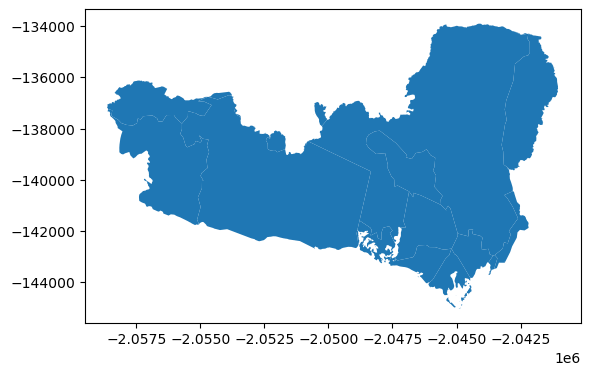

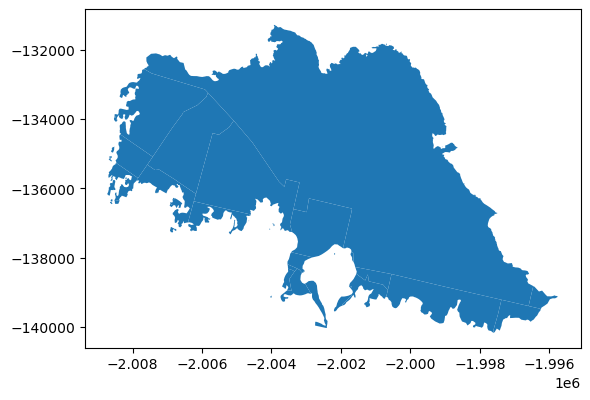

In [ ]:
# Plot the clipped Palisades and EJI map 
eji_palis_clip.plot()

# Plot the clipped Eaton and EJI map
eji_eaton_clip.plot()

Difference between a spatial join and clipping

**Spatial Join `(sjoin)`**

Returns entire census tracts that touch the fire perimeter. The geometry is unchanged. Useful for understanding which social-vulnerability regions are potentially affected. But the tracts may vastly over-represent the area burned, because they remain whole polygons.

**Clipping `(clip)`**

Returns only the portion of each tract inside the fire perimeter. The geometry is modified. Useful for computing statistics specific to the burned area (e.g., population affected). Creates smaller polygons that match the fire boundary.

Key difference:
Spatial join is about linking attributes based on spatial relationships.
Clipping is about cutting geometry to a target boundary.

###  Create Visualization with the Eaton and Palisades Boundaries with the Basemap Using `contextily`

In this visualization, the Eaton and Palisades fire perimeters are overlaid on a basemap using the contextily library to provide geographic context. Displaying both boundaries together helps illustrate their relative locations and extents within Los Angeles County and supports interpretation of subsequent spatial analyses.

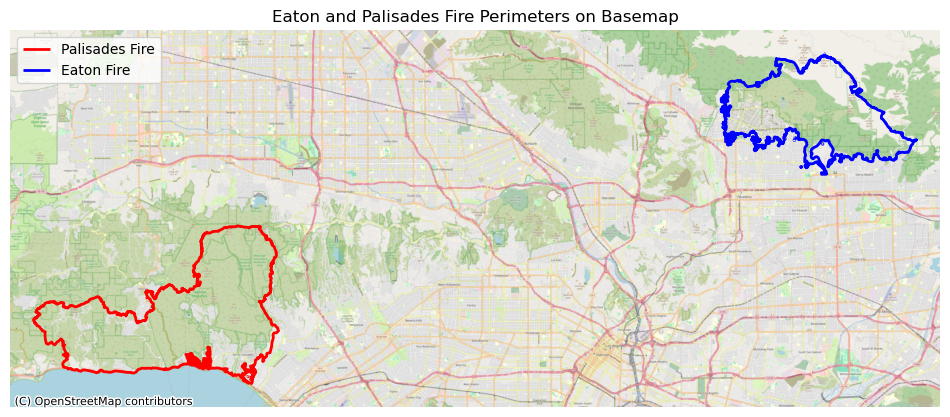

In [ ]:
# Reproject to Web Mercator for the basemap
palisades_3857 = palis_fire.to_crs(epsg=3857)
eaton_3857 = eaton_fire.to_crs(epsg=3857)

# Get bounds from each fire
pminx, pminy, pmaxx, pmaxy = palisades_3857.total_bounds
eminx, eminy, emaxx, emaxy = eaton_3857.total_bounds

minx = min(pminx, eminx)
miny = min(pminy, eminy)
maxx = max(pmaxx, emaxx)
maxy = max(pmaxy, emaxy)

# Plot 
fig, ax = plt.subplots(figsize=(12, 10))

# Set zoom *before* adding basemap
buffer = 2000  # small padding around the fire
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)

# Plot fire boundaries
palisades_3857.boundary.plot(ax=ax, color="red", linewidth=2, label="Palisades Fire")
eaton_3857.boundary.plot(ax=ax, color="blue", linewidth=2, label="Eaton Fire")

# Legend + title
ax.legend(loc = 'upper left')
ax.set_title("Eaton and Palisades Fire Perimeters on Basemap")
ax.axis("off")

plt.show()


The map above displays the locations and extents of the Palisades Fire (outlined in red) and the Eaton Fire (outlined in blue) over a detailed OpenStreetMap basemap of the Los Angeles region. Overlaying the fire boundaries on a familiar street-level basemap allows for clear interpretation of their urban and ecological contexts. This map shows the proximity of the perimeters to major roadways, neighborhoods and parks.

### **Create Final Visualization**

For our final visualization, we plotted census tracts symbolized by the percentage of persons with a disability (E_DISABL) using the 2024 California Environmental Justice Index dataset. This map highlights the spatial distribution of disability prevalence within census tracts intersecting the Eaton and Palisades fire perimeters, which allow us to examine how wildfire exposure overlaps with communities that may face additional challenges during evacuation, emergency response, and recovery. By visualizing this variable at the census-tract level, the map provides important context for understanding social vulnerability alongside the physical extent of the fires.

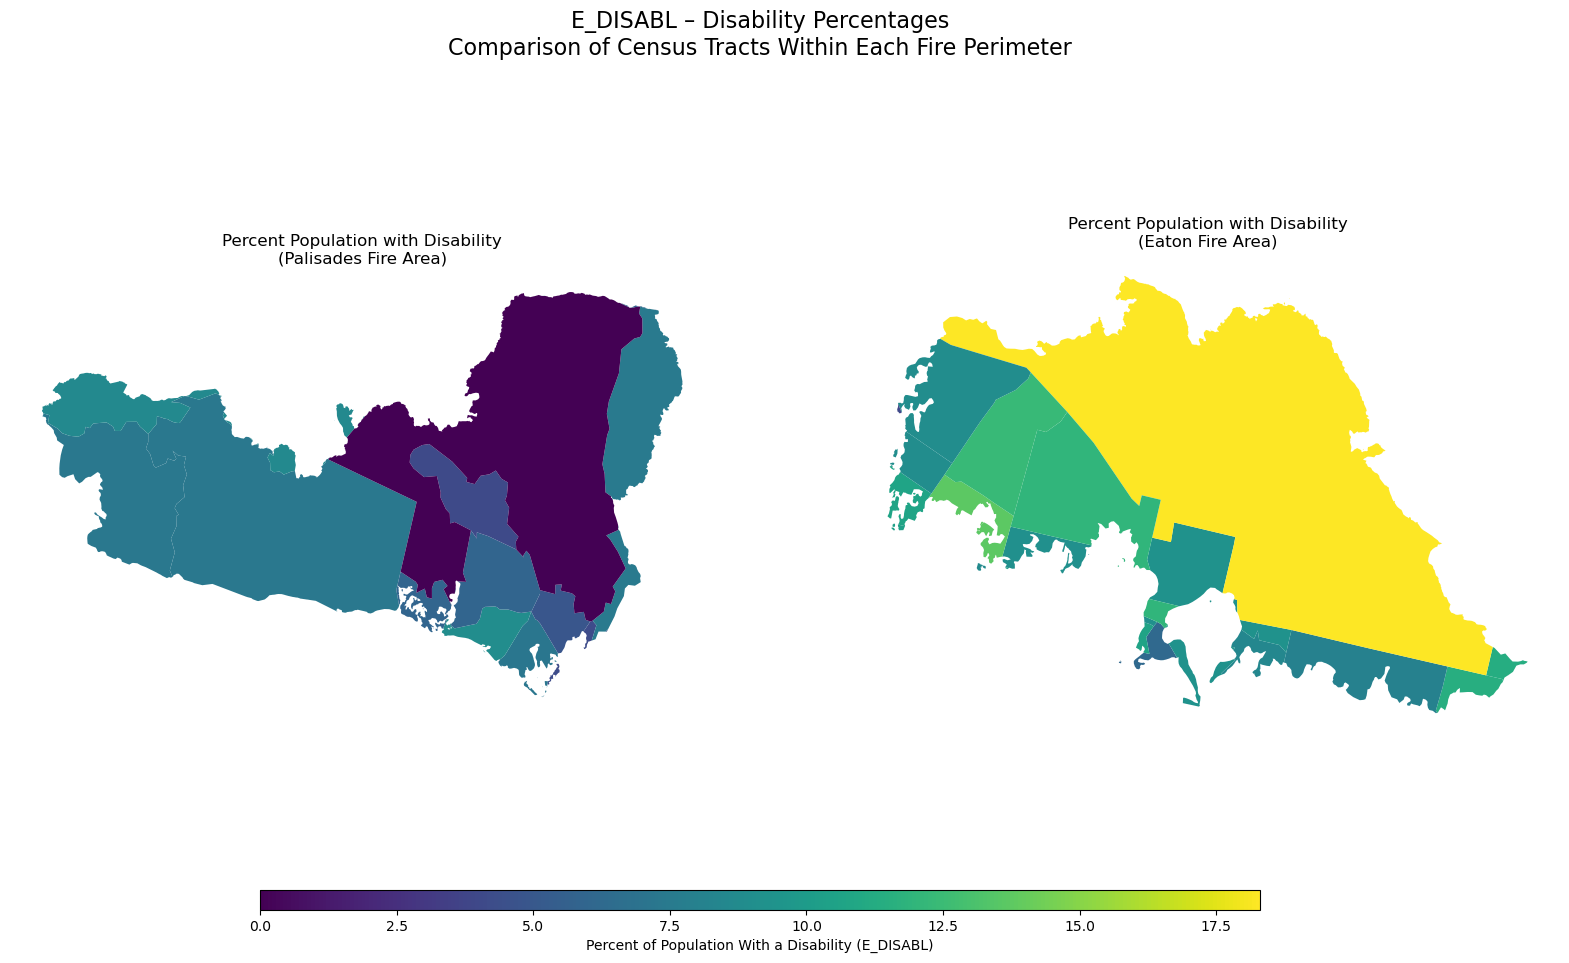

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Your chosen EJI variable from step 1
eji_variable = 'E_DISABL'

# Find shared min/max across BOTH datasets
vmin = min(eji_palis_clip[eji_variable].min(),
           eji_eaton_clip[eji_variable].min())

vmax = max(eji_palis_clip[eji_variable].max(),
           eji_eaton_clip[eji_variable].max())

# --- Palisades plot ---
eji_palis_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap="viridis" 
)
ax1.set_title('Percent Population with Disability\n(Palisades Fire Area)')
ax1.axis('off')

# --- Eaton plot ---
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap="viridis"
)
ax2.set_title('Percent Population with Disability\n(Eaton Fire Area)')
ax2.axis('off')

# Overall title
fig.suptitle('E_DISABL – Disability Percentages\nComparison of Census Tracts Within Each Fire Perimeter',
             fontsize=16)

# Shared horizontal colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percent of Population With a Disability (E_DISABL)')

plt.show()


The distribution of `E_DISABL`, or the percent of residents with disabilities, differs noticeably between the census tracts intersecting the Palisades and Eaton fire perimeters. In the Palisades area, disability percentages are generally lower and more varied, with many tracts falling in the lower end of the color scale. In contrast, the Eaton fire area shows consistently higher disability rates across most tracts, with several communities displaying some of the highest values in the comparison. These differences have important implications for wildfire relief and recovery efforts. Communities with higher proportions of residents with disabilities may face additional challenges during evacuation, communication, and rebuilding phases. This means that emergency managers and recovery planners may need to allocate more targeted resources like accessible transportation, medical support, and long-term housing assistance to the Eaton area to ensure equitable and effective wildfire response.